In [1]:
import cv2 as cv
import numpy as np
import os
from skimage.feature.texture import greycomatrix
from skimage.feature.texture import greycoprops
from skimage.measure import shannon_entropy
import pyfeats
import pandas as pd

## Define Feature Extraction functions

### Read dataset images

In [2]:
def read_images(folder = "dataset/train",
                classes = [
                            "normal",
                            "fatty",
#                             "cirrhosis"
                        ]):
    image_names = {}
    images = {}
    # Get all image names in folders
    for cls in classes:
        image_names[cls] = os.listdir(f'{folder}/{cls}')

    # read all images to list
    for cls in classes:
        images[cls] = []
        for name in image_names[cls]:
            img = cv.imread(f'{folder}/{cls}/{name}', cv.IMREAD_GRAYSCALE)
            images[cls].append(img)
    return images

### Extract ROIs from image

In [3]:
def extract_roi(img, start , size = (32,32)):
    roi = img[start[0]:start[0]+size[0],start[1]:start[1]+size[1]]
    mask = np.zeros(img.shape)
    mask[start[0]:start[0]+size[0],start[1]:start[1]+size[1]] = 1
    return roi, mask

### Extract Features from ROIs

In [4]:
def feature_extraction(img):
    roi_pos = [
        (160,230),
        (118,224),
        (241,151),
        (120,420),
        (170,300),
        (400,200),
        (300,120),
        (240,240),
        (360,160)
    ]
    
    roi_mask_arr = []
    for pos in roi_pos:
        roi_mask_arr.append(extract_roi(img, pos))
    
    # 0 45 90 135 degrees
    angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
    
    da_dict = {
        0: "d1_0",
        1: "d1_45",
        2: "d1_90",
        3: "d1_135",
        
        4: "d2_0",
        5: "d2_45",
        6: "d2_90",
        7: "d2_135",
        
        8: "d3_0",
        9: "d3_45",
        10: "d3_90",
        11: "d3_135",
        
    }
    
    feat_arr = []
    
    for roi, mask in roi_mask_arr:
        features = {}
        
        glcm_mtx = greycomatrix(roi, distances = [1,2,3], angles = angles, levels = 256)
        con = greycoprops(glcm_mtx, 'contrast').flatten()
        hom = greycoprops(glcm_mtx, 'homogeneity').flatten()
        en = greycoprops(glcm_mtx, 'energy').flatten()
        corr = greycoprops(glcm_mtx, 'correlation').flatten()
        
        for j in range(len(da_dict)):
            features[f'contrast_{da_dict[j]}'] = con[j]
            features[f'homogeneity_{da_dict[j]}'] = hom[j]
            features[f'energy_{da_dict[j]}'] = en[j]
            features[f'correlation_{da_dict[j]}'] = corr[j]
            
        features[f'entropy'] = shannon_entropy(roi)

        feat, labels = pyfeats.glrlm_features(img, mask, 256)
        glrlm = {l : f for l,f in zip(labels,feat)}
        features[f'longRunEmphasis'] = glrlm['GLRLM_LongRunEmphasis']
        features[f'runPercentage'] = glrlm['GLRLM_RunPercentage']
        
        feat_arr.append(features)
        
    return feat_arr

### Construct dataframe from ROI features

In [5]:
def build_dataframe(images):
    # dataframe consists of features of 1 ROI per image
    # column name roiNum_feature
    data = pd.DataFrame()

    for cls in images:
        for img in images[cls]:
            feat_arr = feature_extraction(img)
            for row in feat_arr:
                row['target'] = cls
                data = data.append(row,ignore_index=True)
    return data

## Feature Analysis and Selection

### Read data

In [6]:
# images = read_images()
# data = build_dataframe(images)

data40 = pd.read_csv('dataset/roi_40img_9_roi_3d_4a_32p.csv')
data55 = pd.read_csv('dataset/roi_55img_9_roi_3d_4a_32p.csv')
data = data40.append(data55, ignore_index=True)
# remove roi out of ultrasound
# roi made for train set, test set needs other roi
# prepare a mask for each image?
data = data[data['contrast_d1_0'] != 0]

data.describe()

,contrast_d1_0,contrast_d1_135,contrast_d1_45,contrast_d1_90,contrast_d2_0,contrast_d2_135,contrast_d2_45,contrast_d2_90,contrast_d3_0,contrast_d3_135,...,homogeneity_d2_0,homogeneity_d2_135,homogeneity_d2_45,homogeneity_d2_90,homogeneity_d3_0,homogeneity_d3_135,homogeneity_d3_45,homogeneity_d3_90,longRunEmphasis,runPercentage
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,76.015466,232.905736,133.962397,157.187419,189.986520,232.905736,133.962397,337.430265,279.355636,416.520154,...,0.202904,0.181602,0.223971,0.157199,0.172244,0.154430,0.169192,0.151319,1.498451,0.837701
std,150.910433,252.694863,178.941607,131.165359,303.816830,252.694863,178.941607,289.042818,364.144822,480.788211,...,0.161935,0.157704,0.175117,0.160937,0.157917,0.154653,0.162968,0.159231,0.319743,0.136823
min,0.015121,0.034339,0.021852,0.038306,0.025000,0.034339,0.021852,0.045833,0.024784,0.026667,...,0.053075,0.046886,0.054134,0.039637,0.043536,0.034124,0.037732,0.031738,1.284691,0.707023
25%,10.360635,51.718002,34.346774,48.331401,32.287240,51.718002,34.346774,93.577344,57.846444,99.990278,...,0.087843,0.078210,0.104206,0.065509,0.072518,0.061785,0.071081,0.059723,1.303140,0.711369
50%,50.430444,162.884495,100.386056,142.951613,154.346875,162.884495,100.386056,296.540104,241.365302,288.650000,...,0.154191,0.144279,0.163817,0.097969,0.120848,0.107009,0.109492,0.090943,1.334881,0.715008
75%,95.994456,337.355099,192.682362,225.944304,253.248177,337.355099,192.682362,470.327344,373.556573,567.022500,...,0.254396,0.200268,0.269852,0.171258,0.196322,0.166794,0.185941,0.169283,1.558114,0.968543
max,2632.935484,2767.518210,3034.789802,936.995968,5215.625000,2767.518210,3034.789802,1918.854167,5590.637931,5372.873333,...,0.995000,0.994797,0.995317,0.995833,0.995366,0.994667,0.995778,0.993535,3.137791,1.079653


### Mutual information score

In [15]:
from sklearn.model_selection import train_test_split

X = data.copy()
y = X.pop('target')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

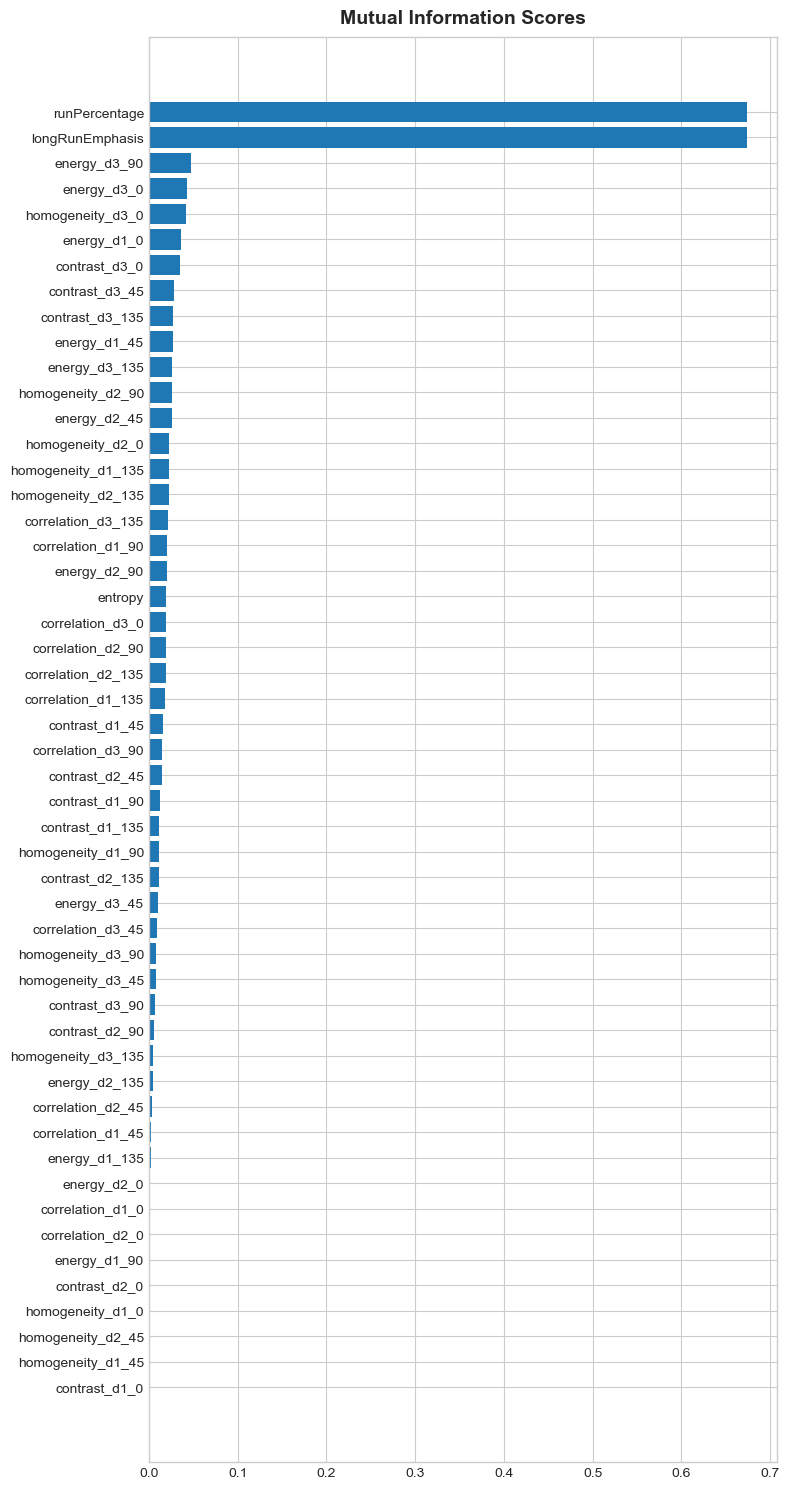

In [20]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

def make_mi_scores(X, y):
    X = X.copy()
    mi_scores = mutual_info_classif(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
mi_scores = make_mi_scores(X, y)

plt.figure(dpi=100, figsize=(8, 15))
plot_mi_scores(mi_scores)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

accuracy_score(y_test, y_pred)

0.6973684210526315

In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_test,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

              precision    recall  f1-score     support
fatty          0.699115  0.868132  0.774510   91.000000
normal         0.692308  0.442623  0.540000   61.000000
accuracy       0.697368  0.697368  0.697368    0.697368
macro avg      0.695711  0.655377  0.657255  152.000000
weighted avg   0.696383  0.697368  0.680397  152.000000


In [23]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)

accuracy_score(y_test, y_pred)

0.9144736842105263

In [24]:
report = classification_report(y_test,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

              precision    recall  f1-score     support
fatty          0.906250  0.956044  0.930481   91.000000
normal         0.928571  0.852459  0.888889   61.000000
accuracy       0.914474  0.914474  0.914474    0.914474
macro avg      0.917411  0.904251  0.909685  152.000000
weighted avg   0.915208  0.914474  0.913790  152.000000


In [ ]:
# data.to_csv("dataset/roi_55img_9_roi_3d_4a_32p.csv",index = False)